In [17]:
import torch
import os
import sys
import numpy as np
from models.rcnn import RecurrentCNN
from models.cnn_classifier import Classifier
from models.cnn_segmentator import Segmentator
import matplotlib.pyplot as plt

sys.path.append('/Users/salvatoreesposito/Desktop/ROIdetection')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [19]:
model = RecurrentCNN().to(device)
path2weights = os.path.join('data', 'weights', 'RecurrentCNN.pt')
model.load_state_dict(torch.load(path2weights, map_location=device))
model.eval()

RecurrentCNN(
  (encoding): EncodingCNN(
    (encoding): Sequential(
      (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): ReLU()
    )
  )
  (biLSTM): LSTM(64, 64, batch_first=True, bidirectional=True)
  (LSTM): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (integrator): Linear(in_features=128, out_features=2, bias=True)
)

Classifier(
  (convBlock): Sequential(
    (0): Block(
      (basic_block): Sequential(
        (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Block(
      (basic_block): Sequential(
        (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Block(
      (basic_block): Sequential(
        (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Block(
      (basic_block): Sequential(
        (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
      )
    )
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

Segmentator(
  (starter): Sequential(
    (0): Block(
      (basic_block): Sequential(
        (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Block(
      (basic_block): Sequential(
        (0): Conv1d(16, 20, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (3): Block(
      (basic_block): Sequential(
        (0): Conv1d(20, 24, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): Block(
      (basic_block): Sequential(
        (0): Conv1d(24, 28, kernel_size

In [20]:
mzml_file = "/Users/salvatoreesposito/Downloads/Beer_multibeers_1_fullscan1.mzML"

In [21]:
from Main import peakonly
rois = peakonly(filepath=mzml_file)
print(len(rois))

0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 

In [22]:
print([len(r.peak_list) for r in rois])
roi = rois[22]

[2, 2, 2, 2, 2, 5, 8, 3, 38, 2, 2, 2, 2, 51, 10, 2, 16, 4, 5, 10, 10, 30, 55, 2, 7, 2, 9, 2, 2, 10, 7, 2]


In [23]:
from roi import ROI as poROI
rr = poROI([roi.peak_list[0].scan,roi.peak_list[-1].scan],
           [roi.peak_list[0].rt,roi.peak_list[-1].rt],
           [p.i for p in roi.peak_list],
           [roi.peak_list[0].mz,roi.peak_list[-1].mz],
           roi.mean_mz)
print(rr)

mz = 126.0662, rt = 530.72 - 599.04


In [26]:
from processing_utils.run_utils import preprocess, correct_classification, get_borders, Feature

lvals = np.arange(10,100,2)
lf = []
print(lvals)
pp = []
for lval in lvals:
    print(lval)
    signal = preprocess(rr.i[:lval], torch.device('cpu'))
    # classifier_output, _ = classifier(signal)
    # _, segmentator_output = segmentator(signal)
    classifier_output, segmentator_output = model(signal)
    classifier_output = classifier_output.data.cpu().numpy()
    
    print(classifier_output)
    label = np.argmax(classifier_output)
    pp.append(classifier_output[0][1])

    segmentator_output = segmentator_output.data.sigmoid().cpu().numpy()
    borders = get_borders(segmentator_output[0, 0, :], segmentator_output[0, 1, :],
                        peak_minimum_points=8)
    features = []
    for border in borders:
        # to do: check correctness of rt calculations
        scan_frequency = (rr.scan[1] - rr.scan[0]) / (rr.rt[1] - rr.rt[0])
        rtmin = rr.rt[0] + border[0] / scan_frequency
        rtmax = rr.rt[0] + border[1] / scan_frequency
        feature = Feature(["AAA"], [roi], [border], [0], [np.sum(rr.i[border[0]:border[1]])],
                          rr.mzmean, rtmin, rtmax, 0, 0)
        features.append(feature)
    lf.append(len(features))

    
    

[10 60]
10
[[ 2.3713589 -1.716725 ]]
60
[[-4.0125465  4.6444216]]


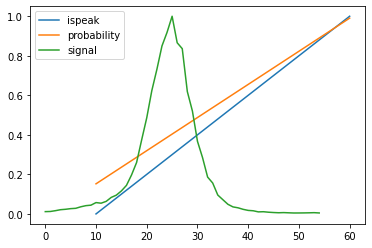

In [27]:
plt.plot(lvals,lf,label='ispeak')
plt.plot(lvals,1/(1+np.exp(-np.array(pp))),label='probability')
plt.plot(range(len(rr.i)),rr.i/max(rr.i),label='signal')
plt.legend()
plt.savefig('example.png')